### DSGE - Linearization Exercises

In [1]:
import scipy.optimize as opt
import numpy as np
import time
from matplotlib import pyplot as plt

%matplotlib inline

#### Exercise 1

In [53]:
# Parameters
alpha = .35
beta = .98
N = .95
sigma = .02
kbar = (beta*alpha)**(1/(1-alpha))

# F, G, H, L, M, P, Q
F = (alpha*beta*kbar**(alpha-1))/(kbar**alpha - kbar)
G = -(alpha*beta*kbar**(alpha -1)*(alpha + kbar**(alpha - 1)))/(kbar**alpha - kbar)
H = (beta*(alpha)**2*kbar**(2*(alpha -1)))/(kbar**alpha - kbar)
L = -(beta*alpha*kbar**(2*alpha-1))/(kbar**alpha - kbar)
M = (beta*(alpha)**2 * kbar**(2*(alpha -1)))/(kbar**alpha - kbar)

P = (-G - np.sqrt(G**2 - 4*F*H))/(2*F) # We pick the root with stability
Q = -(L*N + M)/(F*N + F*P + G)

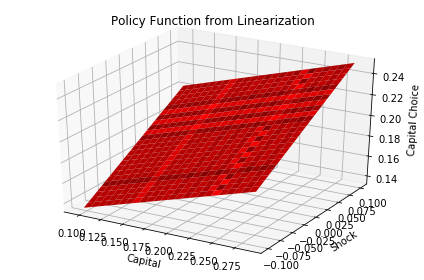

In [54]:
# Generating Grid
# Generate Grid for Capital
kvec = np.linspace(0.5*kbar, 1.5*kbar, 25)

# Generate Grid for Markov Process
import ar1_approx as ar1

pi, zvec = ar1.rouwen(N, 0, 5*sigma/12, 25)

# Lets generate our 3d plot.
from mpl_toolkits.mplot3d import Axes3D

kgrid, zgrid = np.meshgrid(kvec, zvec)
kprime = np.empty((25, 25))
for i in range(25):
    for j in range(25):
        kprime[i,j] = kbar + P*(kvec[i] - kbar) + Q*zvec[j]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(kgrid, zgrid, kprime, rstride = 1, cstride = 1, color='r')
ax1.set_xlabel('Capital')
ax1.set_ylabel('Shock')
ax1.set_zlabel('Capital Choice')
plt.title('Policy Function from Linearization')
plt.tight_layout()
plt.show()

#### Exercise 2

In [58]:
# F, G, H, L, M, P, Q
F2 = (alpha*beta*np.exp(kbar*(alpha -1))* np.exp(kbar))/(np.exp(kbar*alpha) - np.exp(kbar))
G2 = -(alpha*beta*(np.exp(kbar*(2*alpha -1)) + alpha*np.exp(kbar*alpha)))/(np.exp(kbar*alpha) - np.exp(kbar))
H2 = (beta*alpha**2*np.exp(kbar*(2*alpha -1)))/(np.exp(kbar*alpha) - np.exp(kbar))
L2 = - (beta * alpha *np.exp(kbar*alpha))/(np.exp(kbar*alpha) - np.exp(kbar))
M2 = (beta*alpha*np.exp(kbar*(2*alpha -1)))/(np.exp(kbar*alpha) - np.exp(kbar))

P2 = (-G2  - np.sqrt(G2**2 - 4*F2*H2))/(2*F2) # We pick the root with stability
Q2 = -(L2*N + M2)/(F2*N + F2*P2 + G2)

In [60]:
np.sqrt(G2**2 - 4*F2*H2)

1.3674555485577919

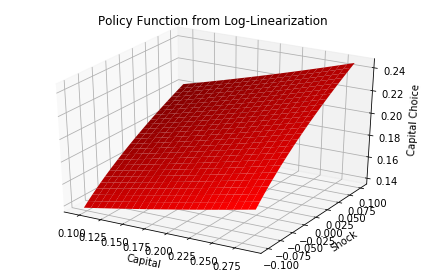

In [67]:
kgrid, zgrid = np.meshgrid(kvec, zvec)
kprime2 = np.empty((25, 25))
kvec2 = np.log(kvec)
for i in range(25):
    for j in range(25):
        kprime2[i,j] = np.exp(np.log(kbar) + P2*(kvec2[i] - np.log(kbar)) + Q2*zvec[j])

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(kgrid, zgrid, kprime2, rstride = 1, cstride = 1, color='r')
ax1.set_xlabel('Capital')
ax1.set_ylabel('Shock')
ax1.set_zlabel('Capital Choice')
plt.title('Policy Function from Log-Linearization')
plt.tight_layout()
plt.show()

#### Exercise 4

As mentioned, we have the following Euler Equations characterizing this system:

$$ c_t^{-\gamma} = \beta \mathbb{E}_t \left\{ c_{t+1}^{-\gamma}[(r_{t+1} - \delta)(1-\tau) - 1]\right\} $$
$$ w(1-\tau)c_t^{-\gamma} = a(1-L)^{-\xi} $$

We will proceed by using the LinApp functions provided to solve for steady state.

In [200]:
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

# Exogenous Parameters
alpha = .4
gamma = 2.5
xi = 1.5
a = .5
beta = .98
delta = .1
tau = .05

params = np.array([alpha, beta, gamma, xi, tau, delta, a])

# Setting Linapp parameters
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
logX = 0
Sylv = 0

# Note here that we are letting k be x (our endogenous state variable), 
#y be l, an endogeneous decision variable, 
#and z be z, an exogenous state variable

# Defining Model function

def modeldef(k0, k1, l, z, params):
    alpha, beta, gamma, xi, tau, delta, a = params
    
    w = (1-alpha)*k0**alpha*l**(-alpha)*np.exp(z)**(1-alpha)
    r = (alpha)*k0**(alpha -1)*l**(1-alpha)*np.exp(z)**(1-alpha)
    T = tau*(w*l + (r-delta)*k0)
    c = (1-tau)*(w*l + (r-delta)*k0) + k0 + T - k1
    y = k0**alpha*(l*np.exp(z))**(1-alpha)
    i = k1 - (1-delta)*k0
    return w, r, T, c, y, i

# Defining Model Dynamics

def modeldyn(theta0, params):
    Kpp, Kp, K, Lp, L, Zp, Z = theta0
    alpha, beta, gamma, xi, tau, delta, a = params
    
    w, r, T, c, y, i = modeldef(K, Kp, L, Z, params)
    wp, rp, Tp, cp, yp, ip = modeldef(Kp, Kpp, Lp,  Zp, params)
    
    E2 = c**(-gamma)/(beta*cp**(-gamma)*((rp - delta)*(1-tau) + 1)) - 1
    E1 = w*(1-tau)*c**(-gamma)/(a*(1 -L)**(-xi)) -1
    
    return np.array([E1, E2])

In [196]:
# Now we can use the linapp functions to find our steady state.
guessKL = np.array([1, .5])
Kbar, Lbar = LinApp_FindSS(modeldyn, params, guessKL, Zbar, nx, ny)
wbar, rbar, Tbar, cbar, ybar, ibar = modeldef(Kbar, Kbar, Lbar, Zbar, params)
print("Model Parameters", "\nKbar = ", Kbar, "\nLbar = ", Lbar, "\nwbar = ", wbar[0],
     "\nrbar = ", rbar[0], "\nTbar = ", Tbar[0], "\ncbar = ", cbar[0], "\nybar = ", ybar[0], 
     "\nibar = ", ibar)

Model Parameters 
Kbar =  4.22522902678 
Lbar =  0.579791453167 
wbar =  1.32795276835 
rbar =  0.121482277121 
Tbar =  0.0430351603077 
cbar =  0.860703206154 
ybar =  1.28322610883 
ibar =  0.422522902678


#### Exercise 5

In [197]:
#In order to compute numerical derivatives, let us form a wrapper around our two functions.

def steadystate(params, guessKL, Z, nx, ny):
    kbar, lbar = LinApp_FindSS(modeldyn, params, guessKL, Z, nx, ny)
    wbar, rbar, Tbar, cbar, ybar, ibar = modeldef(kbar, kbar,lbar, Z, params)
    return np.array([kbar, lbar, wbar, rbar, Tbar, cbar, ybar, ibar])

# Now we can compute numerical derivatives for variations in all of the parameters by using the centered difference

derivmat = np.zeros((8, 8))

for i in range(7): # Loop over parameters in params
    eps = np.zeros(7)
    eps[i] = 1e-2
    paramepsminus = params - params*eps
    paramepsplus = params + params*eps
    diff = np.max(np.abs(paramepsminus - paramepsplus))
    derivmat[:,i] = (steadystate(paramepsminus, guessKL, Zbar, nx, ny) - steadystate(paramepsplus, guessKL,Zbar, nx, ny)) / diff
    
derivmat[:,7] = (steadystate(params, guessKL, np.array([1e-3]), nx, ny) - steadystate(params, guessKL, np.array([-1e-3]), nx, ny))/ (2*1e-3)
print(derivmat)

[[ -2.59895211e+01  -6.63351906e+01  -1.38703720e-01   8.01675092e-01
    2.32322557e+00   4.83538604e+01   1.84931065e+00   2.83828806e+00]
 [  7.69421386e-01  -2.72475484e-01  -1.90331058e-02   1.10006905e-01
    1.38923714e-01  -1.31981347e+00   2.53764826e-01  -1.90317853e-01]
 [ -4.39693711e+00  -8.02281723e+00   1.18127730e-12   3.10862447e-13
    1.64791665e-01   7.28786375e+00   1.13242749e-12   1.32795299e+00]
 [ -2.94035629e-12   1.09614416e+00  -1.61815006e-13  -4.30211422e-14
   -2.26129295e-02  -1.00000000e+00  -1.52655666e-13   7.00828284e-13]
 [ -1.04274574e-01  -8.68943350e-02  -1.41273687e-03   8.16528900e-03
   -8.48983556e-01   1.75571419e-01   1.88357553e-02   2.89087718e-02]
 [ -2.08549147e+00  -1.73788670e+00  -2.82547373e-02   1.63305780e-01
    2.34392311e-01   3.51142838e+00   3.76715106e-01   5.78175435e-01]
 [ -4.68444359e+00  -8.37140576e+00  -4.21251093e-02   2.43473289e-01
    4.66714868e-01   4.12112891e+00   5.61646171e-01   8.62004241e-01]
 [ -2.5989521

#### Exercise 6

In [202]:
# Setting up steady state input vector
theta0 = np.array([Kbar, Kbar, Kbar, Lbar, Lbar, Zbar, Zbar])

NN = rho

[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(modeldyn, params, theta0, nx, ny, nz, logX)
    
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)

print("F = ", FF, "\nG = ", GG, "\nH = ", HH, "\nL = ", LL, "\nM = ", MM, "\nN = ", NN, "\nP = ", PP, "\nQ = ", QQ)

Sylvester equation solver condition is not satisfied; proceed with the original method...
F =  [[-2.9046017]] 
G =  [[ 5.88766154]] 
H =  [[-2.96699916]] 
L =  [[ 2.16849645]] 
M =  [[-2.23635645]] 
N =  0.95 
P =  [[ 0.91529369]] 
Q =  [[ 0.43818289]]


#### Exercise 7

In [236]:
#Initializing Simulation

def getcons(kvec, kpvec, lvec, zvec, params):
    # Useful function to get consumption
    
    alpha, beta, gamma, xi, tau, delta, a = params
    
    w = (1-alpha)*kvec**alpha*lvec**(-alpha)*np.exp(zvec)**(1-alpha)
    r = (alpha)*kvec**(alpha -1)*lvec**(1-alpha)*np.exp(zvec)**(1-alpha)
    c = w*lvec + (r -delta)*kvec + kvec - kpvec
    return c

def simul(P, Q, R, S, init, modelss, params, rho, mu, sigma, n=10000, t =250):
    '''Function to Simulate Time Path for given number of simulations and time period for baseline tax model
    Inputs:
    P, Q, R, S:  Policy Function approximations from Uhlig Matrices
    Init: Initial conditions of Z and X
    ModelSS:  Model SS Values for Z, X, Y
    params: Model parameters
    rho: Persistence of Technology Process
    mu: Mean of shock
    Sigma: Stddev of shock
    n = number of simulations
    t = time period
    
    Outputs:
    C : txn Matrix of Consumption Values
    Y : txn Matrix of GDP
    K : txn Matrix of Capital Stock
    L : txn Matrix of Labor
    I : txn Matrix of Investment
    '''
    
    alpha, beta, gamma, xi, tau, delta, a = params
    zinit, kinit = init
    zbar, kbar, lbar = modelss
    
    shockmat = np.random.normal(loc=mu, scale=sigma, size =(t,n))
    zmat = np.empty((t,n))
    zmat[0,:] = np.ones(n)*(zinit - zbar)
    for i in range(1,t):
        zmat[i,:] = rho*zmat[i-1,:] + shockmat[i,:]
    alpha, beta, gamma, xi, tau, delta, a = params
    
    kmat = np.empty((t+1,n))
    kmat[0,:] = np.ones(n)*(kinit - kbar)
    for i in range(1,t+1):
        kmat[i,:] = P*kmat[i-1,:] + Q*zmat[i-1,:]
        
    
    lmat = np.empty((t,n))
    for i in range(t):
        lmat[i,:] = R*kmat[i,:] +  S*zmat[i,:]
        
    kreal = kbar*np.exp(kmat)
    lreal = lbar*np.exp(lmat)
    zreal = zbar + zmat
    
    I = kreal[1:] - (1-delta)* kreal[:-1]
    L = lreal
    Y = kreal[:-1]**alpha *(np.exp(zreal)*lreal)**(1-alpha) 
    C = getcons(kreal[:-1], kreal[1:], lreal, zreal, params)
    
    return I, Y, C, L


In [239]:
modelss = (0, Kbar, Lbar)
init = (0, Kbar)
I, Y, C, L = simul(PP, QQ, RR, SS, init, modelss, params, rho, 0, .0004 )


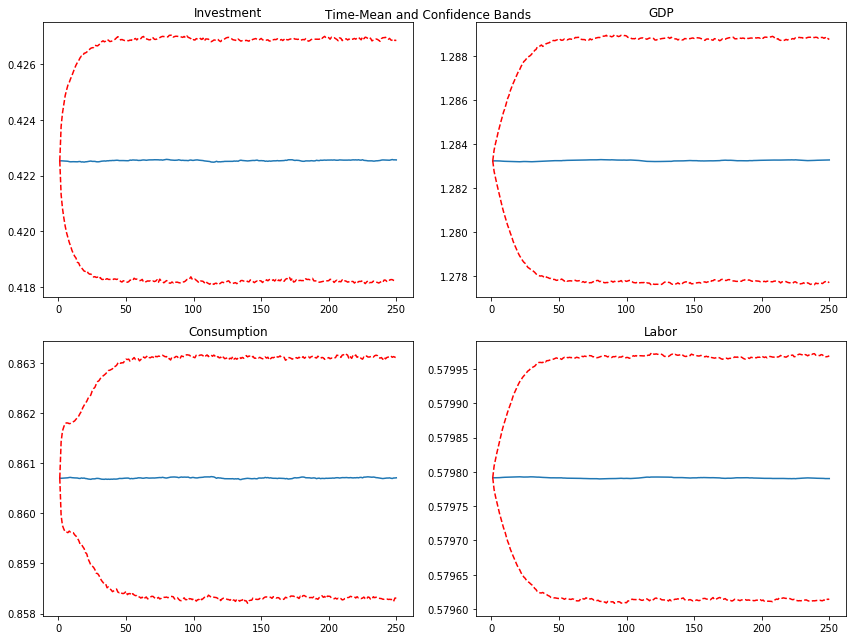

In [262]:
# Lets compute means and confidence intervals and plot each series.

def plotseries(X, conf):
    lower, upper = conf
    Xseries = np.mean(X, axis = 1)
    Xupper = np.percentile(X, upper, axis = 1)
    Xlower = np.percentile(X, lower, axis = 1)
    plt.plot(np.arange(1,251), Xseries, "-")
    plt.plot(np.arange(1,251), Xupper, "r--")
    plt.plot(np.arange(1,251), Xlower, "r--")

# Now we can plot our 4 graphs
plt.figure(figsize=(12,9))
conf = (5,95)
plt.subplot(221)
plotseries(I, conf)
plt.title("Investment")
plt.subplot(222)
plotseries(Y, conf)
plt.title("GDP")
plt.subplot(223)
plotseries(C, conf)
plt.title("Consumption")
plt.subplot(224)
plotseries(L, conf)
plt.title("Labor")

plt.suptitle("Time-Mean and Confidence Bands")
plt.tight_layout()
plt.show()

#### Exercise 8

In [266]:
# Useful Function to print moments

def printmoments(X, Y):
    outvol  = np.std(Y, axis = 0)
    Xmean = np.mean(X, axis = 0)
    Xvol = np.std(X, axis = 0)
    Xcoefv = Xmean / Xvol
    Xrelvol = Xvol / outvol
    Xpers = np.empty(np.shape(X)[1])
    Xcyc = np.empty(np.shape(X)[1])
    for i in range(np.shape(X)[1]):
        Xvec = X[:,i]
        Xpers[i] = np.corrcoef(Xvec[:-1], Xvec[1:])[0,1]
        outvec = Y[:,i]
        Xcyc[i] = np.corrcoef(Xvec, outvec)[0,1]
    print("Mean: Mean = ", np.mean(Xmean), " Std = ", np.std(Xmean), 
          "\nVolatility: Mean = ", np.mean(Xvol), "Std = ", np.std(Xvol),
         "\nCoefficient of Variation = ", np.mean(Xcoefv), "Std = ", np.std(Xcoefv),
         "\nRelative Volatility: Mean = ", np.mean(Xrelvol), "Std = ", np.std(Xrelvol),
         "\nPersistence: Mean = ", np.mean(Xpers), "Std = ", np.std(Xpers), 
         "\nCyclicality: Mean = ", np.mean(Xcyc), "Std = ", np.std(Xcyc))

In [267]:
print("GDP")
printmoments(Y,Y)
print("Consumption")
printmoments(C,Y)
print("Investment")
printmoments(I,Y)
print("Labor")
printmoments(L,Y)

GDP
Mean: Mean =  1.28323990498  Std =  0.00151674503673 
Volatility: Mean =  0.00276333199686 Std =  0.000726680010146 
Coefficient of Variation =  497.890279744 Std =  136.244731723 
Relative Volatility: Mean =  1.0 Std =  0.0 
Persistence: Mean =  0.991561095992 Std =  0.00439719865498 
Cyclicality: Mean =  1.0 Std =  8.29552819469e-17
Consumption
Mean: Mean =  0.860704272878  Std =  0.000492566614407 
Volatility: Mean =  0.00128177638278 Std =  0.000224498815955 
Coefficient of Variation =  691.845816985 Std =  119.494690724 
Relative Volatility: Mean =  0.476310324083 Std =  0.0579977511155 
Persistence: Mean =  0.920692455302 Std =  0.0273076512244 
Cyclicality: Mean =  0.533352872857 Std =  0.129390353493
Investment
Mean: Mean =  0.422535632106  Std =  0.00103001326801 
Volatility: Mean =  0.00231808461184 Std =  0.000459024554559 
Coefficient of Variation =  189.380710714 Std =  37.1765679642 
Relative Volatility: Mean =  0.85468581527 Std =  0.0726119177612 
Persistence: Mean 

#### Generating IRF

In [271]:
def IRF(P, Q, R, S, init, modelss, params, rho, mu, sigma, t = 40):
    '''Function to Generate and plot Impulse Response Function for Baseline Tax Model
    Inputs:
    P, Q, R, S:  Policy Function approximations from Uhlig Matrices
    Init: Initial conditions of Z and X
    ModelSS:  Model SS Values for Z, X, Y
    params: Model parameters
    rho: Persistence of Technology Process
    mu: Mean of shock
    Sigma: Stddev of shock
    n = number of simulations
    t = time period
    
    Outputs:
    C: tx1 path of consumption
    I: tx1 path of Investment
    Y: tx1 path of GDP
    l: tx1 path pf labor
    '''
    I, Y, C, L = simul(PP, QQ, RR, SS, init, modelss, params, rho, 0, .0004 , n=1, t=40)
    plt.figure(figsize=(12,9))
    plt.subplot(221)
    plt.plot(np.arange(1,41), I)
    plt.title("Investment")
    plt.subplot(222)
    plt.plot(np.arange(1,41), Y)
    plt.title("GDP")
    plt.subplot(223)
    plt.plot(np.arange(1,41), C)
    plt.title("Consumption")
    plt.subplot(224)
    plt.plot(np.arange(1,41), L)
    plt.title("Labor")
    plt.tight_layout
    plt.show()
    
    return I, Y, C, L

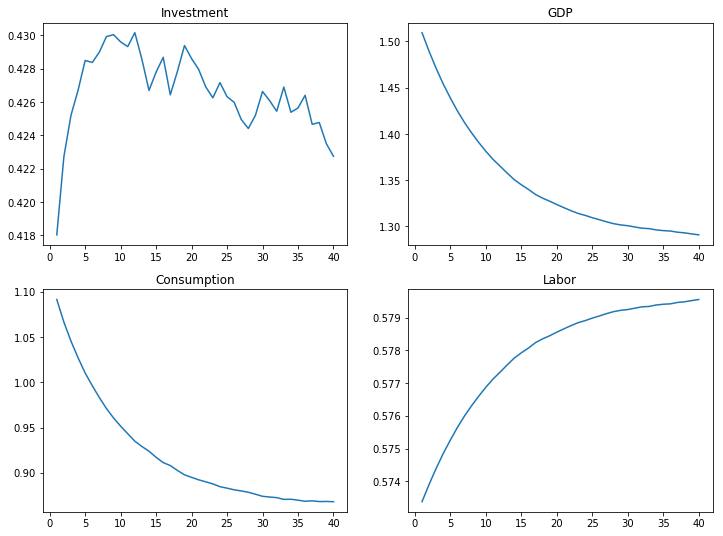

In [272]:
init = (0,1.1*Kbar)
I, Y, C, L = IRF(PP, QQ, RR, SS, init, modelss, params, rho, 0, .0004)


In [280]:
grid = {'1':3,'2':4,'3':5}

for i in range(1,4):
    print(grid[str(i)])

3
4
5


In [281]:
file = open('errors' + str(1) + '.txt', 'w')